In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Train QuickNAT
Working code! Details coming soon!

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.data_utils import get_data, get_imdb_data

from quickNat_pytorch.net_api import squeeze_excitation as se

#torch.set_default_tensor_type('torch.FloatTensor')
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

params ={
    'common':{
        'model_name' : 'quicknat',
        'log_dir_name': 'logs'
    },
    'data' : {
        'base_dir' : "datasets/coronal",
        'train_data_file' : "Data_train.h5", 
        'train_label_file' : "Label_train.h5",
        'train_class_weights_file' : "Class_Weight_train.h5",        
        'train_weights_file' : "Weight_train.h5",                
        'test_data_file' : "Data_test.h5", 
        'test_label_file' : "Label_test.h5",         
        'test_class_weights_file' : "Class_Weight_test.h5",       
        'test_weights_file' : "Weight_test.h5",
        'labels' : ['Background','WM left','GM left','WM right','GM right','Ventricle left','Cerebellar WM left','Cerebellar GM left','Thalamus left','Caudate left',
                    'Putamen left','Pallidum left','3rd ventricle','4th ventricle','Brainstem','Hippo left','Amygdala left','VentralDC left','Ventricle right',
                    'Cerebellar WM right','Cerebellar GM right','Thalamus right','Caudate right','Putamen right','Pallidum right','Hippo right','Amygdala right',
                    'VentralDC right']        
#         'labels' : ['Background','Left WM','Left Cortex','Left Lateral ventricle','Left Inf LatVentricle','Left Cerebellum WM','Left Cerebellum Cortex',
#                     'Left Thalamus','Left Caudate','Left Putamen','Left Pallidum','3rd Ventricle','4th Ventricle','Brain Stem','Left Hippocampus',
#                     'Left Amygdala','CSF (Cranial)','Left Accumbens','Left Ventral DC','Right WM','Right Cortex','Right Lateral Ventricle',
#                     'Right Inf LatVentricle','Right Cerebellum WM','Right Cerebellum Cortex','Right Thalamus','Right Caudate','Right Putamen',
#                     'Right Pallidum','Right Hippocampus','Right Amygdala','Right Accumbens','Right Ventral DC']
    },
    'network' : { 
        'num_class': 28,
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'se_block' : se.SELayer.NONE, # Valid options : se.SELayer.NONE, se.SELayer.CSE, se.SELayer.SSE, se.SELayer.CSSE
        'drop_out' : 0 # Keep 0 for no dropout        
    },
    'training' : {        
        'learning_rate': 1e-3,
        'train_batch_size': 10,
        'val_batch_size': 10,
        'log_nth': 50,
        'num_epochs': 10,
        'lr_scheduler_step_size': 2,
        'lr_scheduler_gamma' : 0.5,
        'exp_dir_name': 'Exp01_try1',
        'final_model_path': 'models/quicknat_final.model',
        'use_last_checkpoint':False #Uses the last checkpoint file from the exp_dir_name folder
    }
}

common_params, train_params, net_params, data_params = params['common'], params['training'], params['network'], params['data']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [ ]:
#train_data, test_data = get_data(data_params)
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

(3240, 256, 256)
27.0
0.0
Train size: 1890
Test size: 1350


## Train Model

In [ ]:
from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_params['train_batch_size'], shuffle=True, num_workers=4, pin_memory = True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=train_params['val_batch_size'], shuffle=False, num_workers=4, pin_memory = True)

quicknat_model = quickNAT(params['network'])

solver = Solver(quicknat_model,
                num_class = net_params['num_class'],
                optim_args={"lr": train_params['learning_rate']},
                model_name = common_params['model_name'],
                labels = data_params['labels'],
                log_nth=train_params['log_nth'], 
                num_epochs=train_params['num_epochs'], 
                log_dir_name = common_params['log_dir_name'],
                exp_dir_name=train_params['exp_dir_name'], 
                lr_scheduler_step_size = train_params['lr_scheduler_step_size'], 
                lr_scheduler_gamma = train_params['lr_scheduler_gamma'],
                use_last_checkpoint =train_params['use_last_checkpoint'])

solver.train(train_loader, val_loader)

START TRAIN.
train : [iteration : 50] : 1.2950456142425537
train : [iteration : 100] : 1.0012028217315674
train : [iteration : 150] : 0.9550669193267822
epoch train loss = 0.7944924235343933
epoch val loss = 16.6768625825
==== Epoch [1 / 10] done ====
Saving model... models/Exp01_try1/quicknat_epoch1.model
train : [iteration : 200] : 0.7256602048873901
train : [iteration : 250] : 0.5934489965438843
train : [iteration : 300] : 0.45085614919662476
train : [iteration : 350] : 0.35124391317367554
epoch train loss = 0.3171236217021942
epoch val loss = 7.25762307202
==== Epoch [2 / 10] done ====
Saving model... models/Exp01_try1/quicknat_epoch2.model
train : [iteration : 400] : 0.35077619552612305
train : [iteration : 450] : 0.29271945357322693
train : [iteration : 500] : 0.2851443588733673
train : [iteration : 550] : 0.25570017099380493
epoch train loss = 0.20211762189865112
epoch val loss = 3.26889257343
==== Epoch [3 / 10] done ====
Saving model... models/Exp01_try1/quicknat_epoch3.model


## Save the Model

When you are satisfied with your training, you can save the model.

In [77]:
quicknat_model.save(train_params['final_model_path'])

Saving model... models/quicknat_final.model


## Deploy Model on Test Data

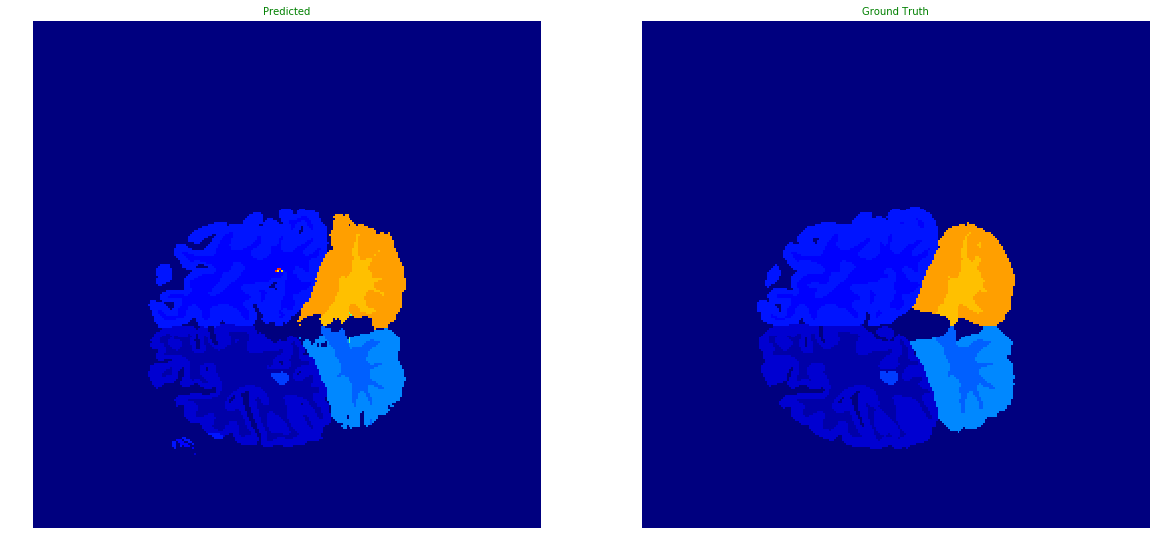

In [78]:
import matplotlib.pyplot as plt

quick_model = torch.load(train_params['final_model_path'])
#quick_model = torch.load('models/Exp01_try1/quicknat_epoch2.model')
with torch.no_grad():
    test_input = Variable(torch.Tensor(test_data.X[1000:1001]).cuda())
    out = quick_model.predict(test_input)
    
groud_truth = test_data.y[1000:1001]
groud_truth = np.squeeze(groud_truth)    


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
ax[0].imshow(out, cmap ='jet', vmin=0, vmax=net_params['num_class']-1)

ax[0].set_title("Predicted", fontsize=10, color = "green")
ax[0].axis('off')
ax[1].imshow(groud_truth, cmap ='jet', vmin=0, vmax=net_params['num_class']-1)
ax[1].set_title("Ground Truth", fontsize=10, color = "green")
ax[1].axis('off')
plt.show()